In [2]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

In [3]:
import numpy as np

In [4]:
import matplotlib
matplotlib.use('AGG')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white") 

# display plots in this notebook
%matplotlib inline

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Naive autoencoder

In [68]:
tf.reset_default_graph()

In [69]:
input_dim = 784
encoding_dim = 100
batch_size = 128

In [70]:
x = tf.placeholder(tf.float32, shape=[None, input_dim])

In [71]:
with tf.variable_scope('encoder') as scope:
    encoder_W = tf.get_variable('W', shape=[input_dim, encoding_dim], initializer=tf.contrib.layers.xavier_initializer())
    encoder_b = tf.get_variable('b', shape=[encoding_dim], initializer=tf.zeros_initializer())
    
with tf.variable_scope('decoder') as scope:
    decoder_W = tf.get_variable('W', shape=[encoding_dim, input_dim], initializer=tf.contrib.layers.xavier_initializer())
    decoder_b = tf.get_variable('b', shape=[input_dim], initializer=tf.zeros_initializer())
    
encoded = tf.nn.relu(tf.matmul(x, encoder_W) + encoder_b)
decoded = tf.nn.sigmoid(tf.matmul(encoded, decoder_W) + decoder_b)

### use tf.layers 

encoded = tf.layers.dense(x, encoding_dim, activation=tf.nn.relu)
decoded = tf.layers.dense(encoded, input_dim, activation=tf.nn.sigmoid)

In [74]:
# loss = tf.nn.l2_loss(decoded - x)
loss = tf.reduce_mean(tf.reduce_sum(tf.square(decoded - x), 1))

In [75]:
train = tf.train.AdamOptimizer().minimize(loss)

In [77]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
for i in range(5001):
    batch_x, _ = mnist.train.next_batch(batch_size)
    sess.run(train, feed_dict={x: batch_x})

    if i % 500 == 0:
        train_loss = sess.run(loss, feed_dict={x: mnist.train.images})
        test_loss = sess.run(loss, feed_dict={x: mnist.test.images})

        print 'iter %d, train loss: %f, test loss: %f' % (i, train_loss, test_loss)

iter 0, train loss: 178.846802, test loss: 178.930542
iter 500, train loss: 13.330675, test loss: 13.034096
iter 1000, train loss: 6.977025, test loss: 6.756349
iter 1500, train loss: 4.553848, test loss: 4.403613
iter 2000, train loss: 3.453329, test loss: 3.351217
iter 2500, train loss: 2.911509, test loss: 2.828223
iter 3000, train loss: 2.570462, test loss: 2.498827
iter 3500, train loss: 2.356742, test loss: 2.298432
iter 4000, train loss: 2.215495, test loss: 2.166842
iter 4500, train loss: 2.099191, test loss: 2.059192
iter 5000, train loss: 2.002178, test loss: 1.971553


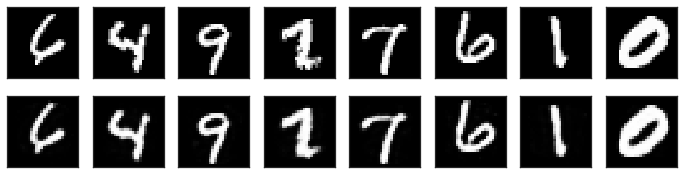

In [78]:
fig, fig_ax = plt.subplots(nrows=2, ncols=8, figsize=(12,3))
for i in range(8):
    random_image = mnist.test.images[np.random.randint(0, 10000, 1), :]
    decoded_image = sess.run(decoded, feed_dict={x: random_image})
    
    plt.subplot(2,8,i+1)
    plt.imshow(random_image.reshape((28,28)), cmap='gray')
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    
    plt.subplot(2,8,i+9)
    
    plt.imshow(decoded_image.reshape((28,28)), cmap='gray')
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])

In [79]:
sess.close()

### write autoencoder as a class

In [5]:
class Autoencoder():
    def __init__(self, input_dim, encoding_dim, activation_func=tf.nn.relu, optimizer=tf.train.AdamOptimizer()):
        self.graph = tf.Graph()
        with self.graph.as_default():     
            self.global_step = tf.Variable(0, name='global_step', trainable=False)

            self.x = tf.placeholder(tf.float32, shape=[None, input_dim])
            self.encoded = tf.layers.dense(self.x, encoding_dim, activation=tf.nn.relu)
            self.decoded = tf.layers.dense(self.encoded, input_dim, activation=tf.nn.sigmoid)

            self.loss = tf.reduce_mean(tf.reduce_sum(tf.square(self.decoded - self.x), 1))
            self.train = optimizer.minimize(self.loss, global_step=self.global_step)
            
            self.saver = tf.train.Saver()
            
            self.init = tf.global_variables_initializer()
        
        self.sess = tf.Session(graph=self.graph)
        self.sess.run(self.init)
        
    def partial_fit(self, x):
        loss, _ = self.sess.run([self.loss, self.train], feed_dict={self.x: x})
        
    def fit(self, x, batch_size=32, epochs=1, validation_data=None):
        pass
    
    def evaluate(self, x):
        return self.sess.run(self.loss, feed_dict={self.x: x})
        
    def predict(self, x):
        return self.sess.run(self.decoded, feed_dict={self.x: x})
    
    def save(self, save_path, global_step=False):
        if global_step:
            self.saver.save(self.sess, save_path, self.global_step)
        else:
            self.saver.save(self.sess, save_path)
        
    def load_weights(self, save_path, latest_checkpoint=False):
        if latest_checkpoint:
            self.saver.restore(self.sess, tf.train.latest_checkpoint(save_path))
        else:
            self.saver.restore(self.sess, save_path)

In [6]:
autoencoder = Autoencoder(input_dim=784, encoding_dim=100)

In [9]:
batch_size = 128
for i in range(5001):
    batch_x, _ = mnist.train.next_batch(batch_size)
    autoencoder.partial_fit(batch_x)

    if i % 500 == 0:
        train_loss = autoencoder.evaluate(mnist.train.images)
        test_loss = autoencoder.evaluate(mnist.test.images)

        print 'iter %d, train loss: %f, test loss: %f' % (i, train_loss, test_loss)

iter 0, train loss: 178.657257, test loss: 178.755432
iter 500, train loss: 12.999808, test loss: 12.726765
iter 1000, train loss: 6.926361, test loss: 6.733581
iter 1500, train loss: 4.507756, test loss: 4.369510
iter 2000, train loss: 3.427318, test loss: 3.323860
iter 2500, train loss: 2.892864, test loss: 2.816402
iter 3000, train loss: 2.546827, test loss: 2.483048
iter 3500, train loss: 2.338739, test loss: 2.287159
iter 4000, train loss: 2.158178, test loss: 2.115149
iter 4500, train loss: 2.063225, test loss: 2.024794
iter 5000, train loss: 1.976449, test loss: 1.944800


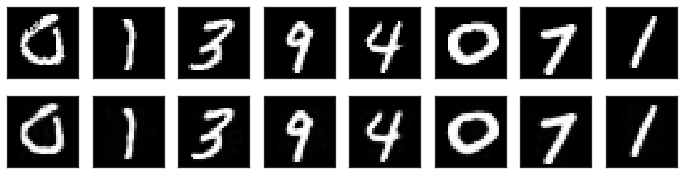

In [11]:
fig, fig_ax = plt.subplots(nrows=2, ncols=8, figsize=(12,3))
for i in range(8):
    random_image = mnist.test.images[np.random.randint(0, 10000, 1), :]
    decoded_image = autoencoder.predict(random_image)
    
    plt.subplot(2,8,i+1)
    plt.imshow(random_image.reshape((28,28)), cmap='gray')
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    
    plt.subplot(2,8,i+9)
    
    plt.imshow(decoded_image.reshape((28,28)), cmap='gray')
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])

In [137]:
autoencoder.sess.close()
autoencoder.sess._closed

True

In [16]:
tf.random_normal(tf.shape(autoencoder.x))

<tf.Tensor 'random_normal:0' shape=(?, 784) dtype=float32>

## denoising autoencoder

In [24]:
class DenoisingAutoencoder():
    def __init__(self, input_dim, encoding_dim, noise_scale=0.1, activation_func=tf.nn.relu, optimizer=tf.train.AdamOptimizer()):
        self.graph = tf.Graph()
        with self.graph.as_default():     
            self.global_step = tf.Variable(0, name='global_step', trainable=False)

            self.x = tf.placeholder(tf.float32, shape=[None, input_dim])
            self.x_noised = tf.clip_by_value(self.x + noise_scale * tf.random_normal(tf.shape(self.x)), 0, 1)
            
            self.encoded = tf.layers.dense(self.x_noised, encoding_dim, activation=tf.nn.relu)
            self.decoded = tf.layers.dense(self.encoded, input_dim, activation=tf.nn.sigmoid)

            self.loss = tf.reduce_mean(tf.reduce_sum(tf.square(self.decoded - self.x), 1))
            self.train = optimizer.minimize(self.loss, global_step=self.global_step)
            
            self.saver = tf.train.Saver()
            
            self.init = tf.global_variables_initializer()
        
        self.sess = tf.Session(graph=self.graph)
        self.sess.run(self.init)
        
    def partial_fit(self, x):
        loss, _ = self.sess.run([self.loss, self.train], feed_dict={self.x: x})
        
    def fit(self, x, batch_size=32, epochs=1, validation_data=None):
        pass
    
    def evaluate(self, x):
        return self.sess.run(self.loss, feed_dict={self.x: x})
        
    def predict(self, x, output_denoised_input=False):
        if output_denoised_input:
            return self.sess.run([self.x_noised, self.decoded], feed_dict={self.x: x})
        else:
            return self.sess.run(self.decoded, feed_dict={self.x: x})
    
    def save(self, save_path, global_step=False):
        if global_step:
            self.saver.save(self.sess, save_path, self.global_step)
        else:
            self.saver.save(self.sess, save_path)
        
    def load_weights(self, save_path, latest_checkpoint=False):
        if latest_checkpoint:
            self.saver.restore(self.sess, tf.train.latest_checkpoint(save_path))
        else:
            self.saver.restore(self.sess, save_path)

In [25]:
autoencoder = DenoisingAutoencoder(input_dim=784, encoding_dim=100, noise_scale=0.3)

In [26]:
batch_size = 128
for i in range(5001):
    batch_x, _ = mnist.train.next_batch(batch_size)
    autoencoder.partial_fit(batch_x)

    if i % 500 == 0:
        train_loss = autoencoder.evaluate(mnist.train.images)
        test_loss = autoencoder.evaluate(mnist.test.images)

        print 'iter %d, train loss: %f, test loss: %f' % (i, train_loss, test_loss)

iter 0, train loss: 178.598694, test loss: 178.651428
iter 500, train loss: 16.723925, test loss: 16.368670
iter 1000, train loss: 10.872842, test loss: 10.593214
iter 1500, train loss: 8.825441, test loss: 8.577472
iter 2000, train loss: 7.726972, test loss: 7.516798
iter 2500, train loss: 7.120375, test loss: 6.982357
iter 3000, train loss: 6.740606, test loss: 6.588512
iter 3500, train loss: 6.475552, test loss: 6.338415
iter 4000, train loss: 6.274497, test loss: 6.157609
iter 4500, train loss: 6.112988, test loss: 5.989004
iter 5000, train loss: 5.993906, test loss: 5.872044


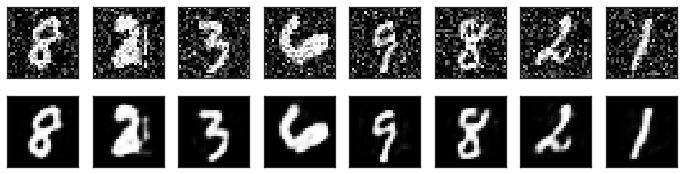

In [27]:
fig, fig_ax = plt.subplots(nrows=2, ncols=8, figsize=(12,3))
for i in range(8):
    random_image = mnist.test.images[np.random.randint(0, 10000, 1), :]
    noisy_image, decoded_image = autoencoder.predict(random_image, output_denoised_input=True)
    
    plt.subplot(2,8,i+1)
    plt.imshow(noisy_image.reshape((28,28)), cmap='gray')
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    
    plt.subplot(2,8,i+9)
    
    plt.imshow(decoded_image.reshape((28,28)), cmap='gray')
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])

In [28]:
autoencoder.save('save/autoencoder_tf/denoising_autoencoder')

In [29]:
autoencoder.sess.close()

In [30]:
autoencoder2 = DenoisingAutoencoder(input_dim=784, encoding_dim=100, noise_scale=0.3)
autoencoder2.load_weights('save/autoencoder_tf/denoising_autoencoder')

INFO:tensorflow:Restoring parameters from save/autoencoder_tf/denoising_autoencoder


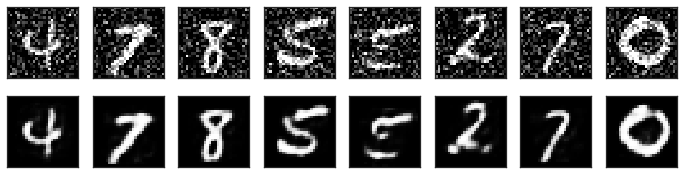

In [31]:
fig, fig_ax = plt.subplots(nrows=2, ncols=8, figsize=(12,3))
for i in range(8):
    random_image = mnist.test.images[np.random.randint(0, 10000, 1), :]
    noisy_image, decoded_image = autoencoder2.predict(random_image, output_denoised_input=True)
    
    plt.subplot(2,8,i+1)
    plt.imshow(noisy_image.reshape((28,28)), cmap='gray')
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    
    plt.subplot(2,8,i+9)
    
    plt.imshow(decoded_image.reshape((28,28)), cmap='gray')
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])

## convolutional autoencoder

In [6]:
class ConvAutoencoder():
    def __init__(self, input_dim, encoding_dim, num_filters=16, noise_scale=0.1, activation_func=tf.nn.relu, optimizer=tf.train.AdamOptimizer()):
        self.graph = tf.Graph()
        with self.graph.as_default():     
            self.input_height = self.input_width = int(np.sqrt(input_dim))
            
            self.global_step = tf.Variable(0, name='global_step', trainable=False)
            
            self.x = tf.placeholder(tf.float32, shape=[None, input_dim])
            self.encoder_h = tf.reshape(self.x, [-1, self.input_height, self.input_width, 1])
            self.encoder_h = tf.layers.conv2d(self.encoder_h, num_filters, [3,3], padding='same', activation=tf.nn.relu)
            self.encoded = tf.layers.max_pooling2d(self.encoder_h, [2,2], strides=2)
            
            self.decoder_h = tf.layers.conv2d(self.encoded, num_filters, [3,3], padding='same', activation=tf.nn.relu)
            self.decoder_h = tf.image.resize_images(self.decoder_h, [self.input_height, self.input_width])
            self.decoder_h = tf.layers.conv2d(self.decoder_h, 1, [3,3], padding='same', activation=tf.nn.sigmoid)
            self.decoded = tf.reshape(self.decoder_h, [-1, input_dim])

            self.loss = tf.reduce_mean(tf.reduce_sum(tf.square(self.decoded - self.x), 1))
            self.train = optimizer.minimize(self.loss, global_step=self.global_step)
            
            self.saver = tf.train.Saver()
            
            self.init = tf.global_variables_initializer()
        
        self.sess = tf.Session(graph=self.graph)
        self.sess.run(self.init)
        
    def partial_fit(self, x):
        loss, _ = self.sess.run([self.loss, self.train], feed_dict={self.x: x})
        
    def fit(self, x, batch_size=32, epochs=1, validation_data=None):
        pass
    
    def evaluate(self, x):
        return self.sess.run(self.loss, feed_dict={self.x: x})
        
    def predict(self, x):
        return self.sess.run(self.decoded, feed_dict={self.x: x})
    
    def save(self, save_path, global_step=False):
        if global_step:
            self.saver.save(self.sess, save_path, self.global_step)
        else:
            self.saver.save(self.sess, save_path)
        
    def load_weights(self, save_path, latest_checkpoint=False):
        if latest_checkpoint:
            self.saver.restore(self.sess, tf.train.latest_checkpoint(save_path))
        else:
            self.saver.restore(self.sess, save_path)

In [7]:
autoencoder = ConvAutoencoder(input_dim=784, encoding_dim=100, noise_scale=0.3)

In [9]:
batch_size = 128
for i in range(501):
    batch_x, _ = mnist.train.next_batch(batch_size)
    autoencoder.partial_fit(batch_x)

    if i % 20 == 0:
        train_loss = autoencoder.evaluate(mnist.train.images)
        test_loss = autoencoder.evaluate(mnist.test.images)

        print 'iter %d, train loss: %f, test loss: %f' % (i, train_loss, test_loss)

iter 0, train loss: 179.031067, test loss: 179.149323


KeyboardInterrupt: 

## variational autoencoder

In [44]:
class VAE():
    def __init__(self, input_dim, intermediate_dim, encoding_dim, activation_func=tf.nn.relu, optimizer=tf.train.AdamOptimizer()):
        self.graph = tf.Graph()
        with self.graph.as_default():     
            self.input_dim = input_dim
            self.intermediate_dim = intermediate_dim
            self.encoding_dim = encoding_dim
            
            self.global_step = tf.Variable(0, name='global_step', trainable=False)

            self.x = tf.placeholder(tf.float32, shape=[None, input_dim])
            self.encoder_h = tf.layers.dense(self.x, intermediate_dim, activation=tf.nn.relu)
            
            self.z_mean = tf.layers.dense(self.encoder_h, encoding_dim, activation=tf.nn.relu)
            self.z_log_sigma = tf.layers.dense(self.encoder_h, encoding_dim, activation=tf.nn.relu)
            epsilon = tf.random_normal(tf.shape(self.z_mean))
            self.z = self.z_mean + tf.exp(self.z_log_sigma) * epsilon
            
            self.decoder_h = tf.layers.dense(self.z, intermediate_dim, activation=tf.nn.relu)
            self.decoder_x_mean = tf.layers.dense(self.decoder_h, input_dim, activation=tf.nn.sigmoid)

            cross_entropy_loss = 0.5 * tf.reduce_sum(tf.square(self.decoder_x_mean - self.x), 1)
            kl_div_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma - tf.square(self.z_mean) - tf.exp(self.z_log_sigma), axis=1)
            self.loss = tf.reduce_mean(cross_entropy_loss + kl_div_loss)
            
            self.train = optimizer.minimize(self.loss, global_step=self.global_step)
            
            self.saver = tf.train.Saver()
            
            self.init = tf.global_variables_initializer()
        
        self.sess = tf.Session(graph=self.graph)
        self.sess.run(self.init)
        
    def partial_fit(self, x):
        loss, _ = self.sess.run([self.loss, self.train], feed_dict={self.x: x})
        
    def fit(self, x, batch_size=32, epochs=1, validation_data=None):
        pass
    
    def evaluate(self, x):
        return self.sess.run(self.loss, feed_dict={self.x: x})
        
    def predict(self, x):
        return self.sess.run(self.decoder_x_mean, feed_dict={self.x: x})
    
    def generate(self):
        z_sample = np.random.normal(size=(1, self.encoding_dim))

        return self.sess.run(self.decoder_x_mean, feed_dict={self.z: z_sample})
    
    def save(self, save_path, global_step=False):
        if global_step:
            self.saver.save(self.sess, save_path, self.global_step)
        else:
            self.saver.save(self.sess, save_path)
        
    def load_weights(self, save_path, latest_checkpoint=False):
        if latest_checkpoint:
            self.saver.restore(self.sess, tf.train.latest_checkpoint(save_path))
        else:
            self.saver.restore(self.sess, save_path)

In [45]:
vae = VAE(input_dim=784, intermediate_dim=200, encoding_dim=100)

In [47]:
batch_size = 128
for i in range(5001):
    batch_x, _ = mnist.train.next_batch(batch_size)
    vae.partial_fit(batch_x)

    if i % 500 == 0:
        train_loss = vae.evaluate(mnist.train.images)
        test_loss = vae.evaluate(mnist.test.images)

        print 'iter %d, train loss: %f, test loss: %f' % (i, train_loss, test_loss)

iter 0, train loss: 24.564919, test loss: 24.596533
iter 500, train loss: 24.352327, test loss: 24.342535
iter 1000, train loss: 24.220596, test loss: 24.234760
iter 1500, train loss: 24.162922, test loss: 24.155174
iter 2000, train loss: 24.044586, test loss: 24.051941
iter 2500, train loss: 23.959476, test loss: 23.976000
iter 3000, train loss: 23.885210, test loss: 23.874107
iter 3500, train loss: 23.824905, test loss: 23.809700
iter 4000, train loss: 23.719234, test loss: 23.705162
iter 4500, train loss: 23.617918, test loss: 23.616261
iter 5000, train loss: 23.501663, test loss: 23.471193


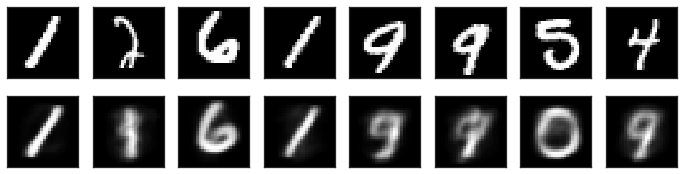

In [48]:
fig, fig_ax = plt.subplots(nrows=2, ncols=8, figsize=(12,3))
for i in range(8):
    random_image = mnist.test.images[np.random.randint(0, 10000, 1), :]
    decoded_image = vae.predict(random_image)
    
    plt.subplot(2,8,i+1)
    plt.imshow(random_image.reshape((28,28)), cmap='gray')
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    
    plt.subplot(2,8,i+9)
    
    plt.imshow(decoded_image.reshape((28,28)), cmap='gray')
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])

[]

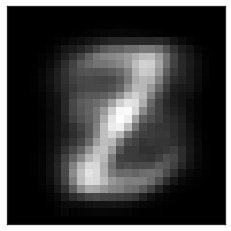

In [49]:
plt.figure()
plt.imshow(vae.generate().reshape((28,28)), cmap='gray')
plt.gca().set_xticks([])
plt.gca().set_yticks([])

In [50]:
vae.sess.close()

## conditional VAE

In [51]:
class ConditionalVAE():
    def __init__(self, input_dim, label_dim, intermediate_dim, encoding_dim, activation_func=tf.nn.relu, optimizer=tf.train.AdamOptimizer()):
        self.graph = tf.Graph()
        with self.graph.as_default():  
            self.input_dim = input_dim
            self.label_dim = label_dim
            self.intermediate_dim = intermediate_dim
            self.encoding_dim = encoding_dim
            
            self.global_step = tf.Variable(0, name='global_step', trainable=False)

            self.x = tf.placeholder(tf.float32, shape=[None, input_dim])
            self.y = tf.placeholder(tf.float32, shape=[None, label_dim])
            self.encoder_input = tf.concat([self.x, self.y], axis=1)
            self.encoder_h = tf.layers.dense(self.encoder_input, intermediate_dim, activation=tf.nn.relu)
            
            self.z_mean = tf.layers.dense(self.encoder_h, encoding_dim, activation=tf.nn.relu)
            self.z_log_sigma = tf.layers.dense(self.encoder_h, encoding_dim, activation=tf.nn.relu)
            epsilon = tf.random_normal(tf.shape(self.z_mean))
            self.z = self.z_mean + tf.exp(self.z_log_sigma) * epsilon
            
            self.decoder_input = tf.concat([self.z, self.y], axis=1)
            self.decoder_h = tf.layers.dense(self.decoder_input, intermediate_dim, activation=tf.nn.relu)
            self.decoder_x_mean = tf.layers.dense(self.decoder_h, input_dim, activation=tf.nn.sigmoid)

            cross_entropy_loss = 0.5 * tf.reduce_sum(tf.square(self.decoder_x_mean - self.x), 1)
            kl_div_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma - tf.square(self.z_mean) - tf.exp(self.z_log_sigma), axis=1)
            self.loss = tf.reduce_mean(cross_entropy_loss + kl_div_loss)
            
            self.train = optimizer.minimize(self.loss, global_step=self.global_step)
            
            self.saver = tf.train.Saver()
            
            self.init = tf.global_variables_initializer()
        
        self.sess = tf.Session(graph=self.graph)
        self.sess.run(self.init)
        
    def partial_fit(self, x, y):
        loss, _ = self.sess.run([self.loss, self.train], feed_dict={self.x: x, self.y: y})
        
    def fit(self, x, batch_size=32, epochs=1, validation_data=None):
        pass
    
    def evaluate(self, x, y):
        return self.sess.run(self.loss, feed_dict={self.x: x, self.y: y})
        
    def predict(self, x, y):
        return self.sess.run(self.decoder_x_mean, feed_dict={self.x: x, self.y: y})
    
    def generate(self, y):
        z_sample = np.random.normal(size=(1, self.encoding_dim))

        return self.sess.run(self.decoder_x_mean, feed_dict={self.y: y, self.z: z_sample})
    
    def save(self, save_path, global_step=False):
        if global_step:
            self.saver.save(self.sess, save_path, self.global_step)
        else:
            self.saver.save(self.sess, save_path)
        
    def load_weights(self, save_path, latest_checkpoint=False):
        if latest_checkpoint:
            self.saver.restore(self.sess, tf.train.latest_checkpoint(save_path))
        else:
            self.saver.restore(self.sess, save_path)

In [52]:
vae = ConditionalVAE(input_dim=784, label_dim=10, intermediate_dim=200, encoding_dim=100)

In [53]:
batch_size = 128
for i in range(5001):
    batch_x, batch_y = mnist.train.next_batch(batch_size)
    vae.partial_fit(batch_x, batch_y)

    if i % 500 == 0:
        train_loss = vae.evaluate(mnist.train.images, mnist.train.labels)
        test_loss = vae.evaluate(mnist.test.images, mnist.test.labels)

        print 'iter %d, train loss: %f, test loss: %f' % (i, train_loss, test_loss)

iter 0, train loss: 92.517853, test loss: 92.614601
iter 500, train loss: 22.096178, test loss: 21.989105
iter 1000, train loss: 21.199018, test loss: 21.085653
iter 1500, train loss: 20.899466, test loss: 20.735039
iter 2000, train loss: 20.638849, test loss: 20.530983
iter 2500, train loss: 20.365269, test loss: 20.219828
iter 3000, train loss: 20.168455, test loss: 20.009113
iter 3500, train loss: 19.995363, test loss: 19.900917
iter 4000, train loss: 19.902369, test loss: 19.750334
iter 4500, train loss: 19.812733, test loss: 19.666019
iter 5000, train loss: 19.715862, test loss: 19.618422


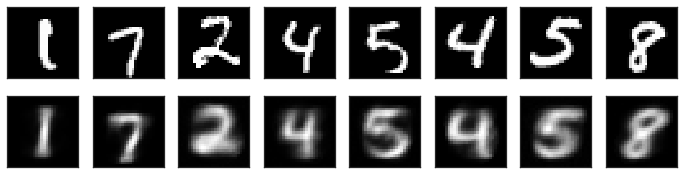

In [54]:
fig, fig_ax = plt.subplots(nrows=2, ncols=8, figsize=(12,3))
for i in range(8):
    random_number = np.random.randint(0, 10000, 1)
    image, label = mnist.test.images[random_number, :], mnist.test.labels[random_number, :]
    decoded_image = vae.predict(image, label)
    
    plt.subplot(2,8,i+1)
    plt.imshow(image.reshape((28,28)), cmap='gray')
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    
    plt.subplot(2,8,i+9)
    
    plt.imshow(decoded_image.reshape((28,28)), cmap='gray')
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])

2


[]

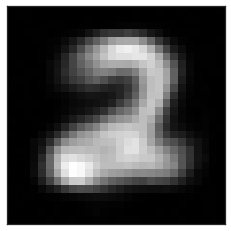

In [60]:
n_samples = 1
y_dim=10
y_sample = np.zeros(shape=[n_samples, y_dim])
for k in range(n_samples):
    digit = np.random.randint(0, y_dim)
    print digit
    y_sample[k, digit] = 1

plt.figure()
plt.imshow(vae.generate(y_sample).reshape((28,28)), cmap='gray')
plt.gca().set_xticks([])
plt.gca().set_yticks([])

In [28]:
vae.sess.close()